In [1]:
import scipy
import scipy.ndimage
from scipy.cluster.vq import vq, kmeans, whiten
from scipy import misc

import numpy as np
import time
import matplotlib.pyplot as plt
import imageio
import PIL
import pickle

### Lectura y visualización de una imagen

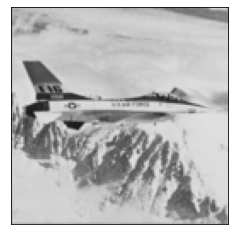

[[167 189 190 ... 193 196 182]
 [160 179 177 ... 209 188 185]
 [161 171 166 ... 181 168 170]
 ...
 [187 208 209 ... 124 135 169]
 [192 213 211 ... 137 155 187]
 [168 187 186 ... 134 142 163]]


In [2]:
imagen=imageio.imread('./img/img_10.png')

(n,m)=imagen.shape # filas y columnas de la imagen

plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(imagen, cmap=plt.cm.gray,vmin=0, vmax=255)
plt.show()
print(imagen)

# Cuantización escalar

**Definid una función** `Cuantizacion_uniforme_adaptativa(imagen, bits=3, n_bloque=8)`
    **que dada una imagen cuantize uniformemente los valores en cada bloque.**

```
imagen: imagen a cuantizar
bits: número de bits necesarios para cuantizar cada bloque, 
      o sea que en cada bloque habrá 2**bits valores diferentes 
      como máximo
n_bloque: se consideran bloques de tamaño n_bloque*n_bloque 

imagenCodigo: es una lista de la forma
[[n,m,n_bloque,bits],[[minimo,maximo],bloqueCodificado],...,[[minimo,maximo],bloqueCodificado]]

siendo:
[n,m,n_bloque,bits] información de la imagen
  n: número de filas de la imagen
  m: número de columnas de la imagen
  n_bloque: tamaño de los bloques usados (divisor de n y m)
  bits: número de bits necesarios para codificar los 
        niveles de recontrucción.
Ejemplo: [1024, 1024, 8, 3]

[[minimo,maximo],bloqueCodificado] información de cada bloque codificado
  minimo: valor mínimo del bloque
  maximo: valor máximo del bloque
  bloqueCodificado: array de tamaño n_bloque*n_bloque que contiene 
       en cada posición a que intervalo de cuantización correspondía 
       el valor del píxel correspondiente en la imagen

Ejemplo: sabemos que trabajamos con bloques 8x8 y que hemos cuantizado en 2**3=8 niveles
    [[85, 150], 
    Array([[4, 0, 0, 4, 7, 7, 6, 7], 
           [4, 3, 1, 1, 4, 7, 7, 6],
           [6, 6, 3, 0, 0, 4, 6, 6], 
           [6, 6, 5, 3, 1, 0, 3, 6],
           [6, 5, 6, 6, 4, 0, 0, 3],
           [5, 6, 6, 6, 6, 4, 2, 0],
           [6, 6, 5, 5, 6, 7, 4, 1],
           [6, 6, 5, 5, 5, 6, 6, 5]]  
   El valor mínimo de los píxeles del bloque era 85 y el máximo 150, por lo 
   tanto los límites de decisión son:
       [85.0, 93.25, 101.5, 109.75, 118.0, 126.25, 134.5, 142.75, 151.0]
   el valor del primer pixel (4) estaría entre 109.75<=p<118
   el valor del segundo pixel pixel (0) estaría entre 85<=p<93.25...
   
      
Importante: Trabajar con Arrays de Numpy

``` 


In [3]:
def Cuantizacion_uniforme_adaptativa(imagen, bits=3, n_bloque=8):
    
    num = 2**bits
    dim = imagen.shape
    
    lis = [[dim[0],dim[1],n_bloque, bits]]
    
    for i in range(0,dim[0], n_bloque):
        for j in range(0,dim[1], n_bloque):
            
            bloqueCodificado = imagen[i:i+n_bloque, j:j+n_bloque]
            
            l = min([min(x) for x in bloqueCodificado])
            u = max([max(x) for x in bloqueCodificado])

            #lim = [l + (u-l+1)*i/num for i in range(num+1)]
            bloqueCodificado = np.floor((bloqueCodificado-l)/((u-l)/num))
            
            #bloqueCodificado = np.array([np.floor((xi-l)/((u-l)/num)) for xi in bloqueCodificado])
            #print(bloqueCodificado)
            
            lis.append([[l,u],bloqueCodificado])
            
    
    return lis

In [4]:
lista =  Cuantizacion_uniforme_adaptativa(imagen)
print(lista)

[[128, 128, 8, 3], [[146, 192], Array([[3., 7., 7., 7., 8., 7., 7., 7.],
       [2., 5., 5., 5., 5., 7., 7., 7.],
       [2., 4., 3., 2., 3., 5., 6., 6.],
       [1., 5., 5., 5., 5., 5., 5., 5.],
       [1., 6., 5., 5., 5., 5., 4., 4.],
       [0., 4., 4., 4., 6., 6., 5., 5.],
       [0., 4., 1., 1., 5., 7., 6., 5.],
       [0., 3., 1., 4., 7., 6., 5., 6.]])], [[159, 196], Array([[5., 5., 6., 6., 6., 6., 6., 6.],
       [6., 7., 7., 7., 7., 8., 7., 7.],
       [6., 6., 6., 6., 6., 7., 7., 7.],
       [5., 5., 4., 4., 5., 4., 4., 5.],
       [4., 3., 1., 0., 1., 3., 4., 5.],
       [5., 3., 1., 0., 0., 4., 6., 7.],
       [5., 3., 2., 3., 4., 6., 7., 6.],
       [3., 1., 1., 4., 7., 8., 6., 3.]])], [[155, 198], Array([[6., 7., 7., 7., 7., 7., 6., 6.],
       [7., 7., 7., 8., 7., 7., 7., 7.],
       [7., 8., 7., 7., 7., 8., 7., 7.],
       [5., 7., 7., 7., 7., 7., 7., 7.],
       [6., 5., 3., 4., 5., 5., 7., 6.],
       [7., 3., 1., 0., 0., 2., 6., 7.],
       [5., 3., 3., 3., 3., 4., 4.

In [5]:
    n_bloque = 8
    bits = 3
    num = 2**bits
    
    
    img = np.array([[0, 0, 0, 4, 7, 7, 6, 7], 
           [4, 3, 1, 1, 4, 7, 7, 6],
           [6, 6, 3, 0, 0, 4, 6, 6], 
           [6, 6, 5, 3, 1, 0, 3, 6],
           [6, 5, 6, 6, 4, 0, 0, 3],
           [5, 6, 6, 6, 6, 4, 2, 0],
           [6, 6, 5, 5, 6, 7, 4, 1],
           [6, 6, 5, 5, 5, 6, 6, 5]])
    
    l = min([min(x) for x in img])
    u = max([max(x) for x in img])
    
    
    lim = [l + (u-l+1)*i/num for i in range(num)]
    print(lim)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]


In [6]:
N = [[1,2,3],[4,15,6],[5,4,8]]

max(max(N))

8

**Definid una función** `Dibuja_imagen_cuantizada(imagenCodigo)`
    **que dada una imagen codificada por la función** 
`Cuantizacion_uniforme_adaptativa` **muestre la imagen.**


In [7]:
def Dibuja_imagen_cuantizada(imagenCodigo):
    tag = imagenCodigo.pop(0)
    dim = [_,_]
    dim[0],dim[1], n_bloque, bits = tag
    num = 2**bits
    num_bloques = [d//n_bloque for d in dim]
    img = np.array([])
    img_col = np.array([])
    for i in range(num_bloques[0]):
        for j in range(num_bloques[1]):
            [l,u],bloqueCodificado = imagenCodigo[i*num_bloques[1]+j]
            bloqueDescodificado = ((bloqueCodificado.astype('uint16'))*(u-l)/num)
            bloqueDescodificado = bloqueDescodificado + l
            print(l,u,bloqueCodificado,bloqueDescodificado, (u-l)/num)
            if (j == 0):
                img_col = bloqueDescodificado
            else:
                img_col = np.append(img_col, bloqueDescodificado, axis=1)
        if (i == 0):
            img = img_col
        else:
            img = np.append(img, img_col, axis=0)
    img_sol = PIL.Image.fromarray(img.astype(np.uint8))
    return img_sol

[[128, 128, 8, 3], [[146, 192], Array([[3., 7., 7., 7., 8., 7., 7., 7.],
       [2., 5., 5., 5., 5., 7., 7., 7.],
       [2., 4., 3., 2., 3., 5., 6., 6.],
       [1., 5., 5., 5., 5., 5., 5., 5.],
       [1., 6., 5., 5., 5., 5., 4., 4.],
       [0., 4., 4., 4., 6., 6., 5., 5.],
       [0., 4., 1., 1., 5., 7., 6., 5.],
       [0., 3., 1., 4., 7., 6., 5., 6.]])], [[159, 196], Array([[5., 5., 6., 6., 6., 6., 6., 6.],
       [6., 7., 7., 7., 7., 8., 7., 7.],
       [6., 6., 6., 6., 6., 7., 7., 7.],
       [5., 5., 4., 4., 5., 4., 4., 5.],
       [4., 3., 1., 0., 1., 3., 4., 5.],
       [5., 3., 1., 0., 0., 4., 6., 7.],
       [5., 3., 2., 3., 4., 6., 7., 6.],
       [3., 1., 1., 4., 7., 8., 6., 3.]])], [[155, 198], Array([[6., 7., 7., 7., 7., 7., 6., 6.],
       [7., 7., 7., 8., 7., 7., 7., 7.],
       [7., 8., 7., 7., 7., 8., 7., 7.],
       [5., 7., 7., 7., 7., 7., 7., 7.],
       [6., 5., 3., 4., 5., 5., 7., 6.],
       [7., 3., 1., 0., 0., 2., 6., 7.],
       [5., 3., 3., 3., 3., 4., 4.

 [194.25  194.25  194.25  194.25  194.25  194.25  194.25  188.875]] 5.375
180 199 [[7. 7. 7. 7. 5. 5. 6. 6.]
 [7. 7. 8. 8. 7. 7. 7. 8.]
 [5. 3. 3. 4. 5. 5. 5. 6.]
 [3. 2. 1. 2. 2. 3. 0. 0.]
 [6. 5. 3. 3. 3. 5. 4. 5.]
 [7. 7. 5. 5. 6. 5. 5. 6.]
 [7. 7. 6. 6. 6. 5. 5. 5.]
 [5. 6. 6. 6. 7. 7. 6. 7.]] [[196.625 196.625 196.625 196.625 191.875 191.875 194.25  194.25 ]
 [196.625 196.625 199.    199.    196.625 196.625 196.625 199.   ]
 [191.875 187.125 187.125 189.5   191.875 191.875 191.875 194.25 ]
 [187.125 184.75  182.375 184.75  184.75  187.125 180.    180.   ]
 [194.25  191.875 187.125 187.125 187.125 191.875 189.5   191.875]
 [196.625 196.625 191.875 191.875 194.25  191.875 191.875 194.25 ]
 [196.625 196.625 194.25  194.25  194.25  191.875 191.875 191.875]
 [191.875 194.25  194.25  194.25  196.625 196.625 194.25  196.625]] 2.375
182 202 [[6. 6. 6. 6. 6. 6. 7. 8.]
 [7. 6. 7. 7. 6. 6. 6. 6.]
 [5. 5. 6. 7. 6. 6. 6. 6.]
 [0. 1. 0. 2. 4. 4. 4. 5.]
 [3. 4. 3. 3. 2. 3. 2. 2.]
 [4. 4. 5. 5. 3

 [211.    157.375  68.     68.     68.     68.     68.     68.   ]] 17.875
76 208 [[3. 5. 7. 7. 7. 7. 7. 7.]
 [0. 1. 5. 7. 7. 7. 7. 7.]
 [0. 0. 1. 5. 7. 7. 7. 7.]
 [0. 0. 0. 1. 5. 8. 7. 7.]
 [0. 0. 0. 0. 1. 5. 7. 7.]
 [0. 0. 0. 0. 0. 1. 5. 7.]
 [0. 0. 0. 0. 0. 0. 1. 5.]
 [0. 0. 0. 0. 0. 0. 0. 1.]] [[125.5 158.5 191.5 191.5 191.5 191.5 191.5 191.5]
 [ 76.   92.5 158.5 191.5 191.5 191.5 191.5 191.5]
 [ 76.   76.   92.5 158.5 191.5 191.5 191.5 191.5]
 [ 76.   76.   76.   92.5 158.5 208.  191.5 191.5]
 [ 76.   76.   76.   76.   92.5 158.5 191.5 191.5]
 [ 76.   76.   76.   76.   76.   92.5 158.5 191.5]
 [ 76.   76.   76.   76.   76.   76.   92.5 158.5]
 [ 76.   76.   76.   76.   76.   76.   76.   92.5]] 16.5
176 208 [[5. 5. 4. 4. 3. 4. 5. 5.]
 [5. 5. 5. 5. 4. 4. 4. 4.]
 [5. 5. 5. 5. 5. 5. 4. 4.]
 [5. 4. 3. 4. 4. 4. 3. 3.]
 [5. 4. 3. 4. 3. 3. 3. 3.]
 [6. 5. 5. 4. 4. 3. 3. 4.]
 [7. 6. 5. 5. 4. 4. 3. 4.]
 [0. 8. 7. 6. 6. 4. 4. 5.]] [[196. 196. 192. 192. 188. 192. 196. 196.]
 [196. 196. 196. 19

79 218 [[7. 6. 4. 1. 1. 1. 1. 3.]
 [8. 6. 1. 1. 1. 2. 2. 2.]
 [7. 5. 1. 1. 2. 3. 2. 1.]
 [7. 2. 0. 1. 2. 1. 1. 3.]
 [4. 1. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0. 0. 0.]] [[200.625 183.25  148.5    96.375  96.375  96.375  96.375 131.125]
 [218.    183.25   96.375  96.375  96.375 113.75  113.75  113.75 ]
 [200.625 165.875  96.375  96.375 113.75  131.125 113.75   96.375]
 [200.625 113.75   79.     96.375 113.75   96.375  96.375 131.125]
 [148.5    96.375  96.375  96.375  79.     79.     96.375  96.375]
 [ 96.375  96.375  96.375  79.     79.     79.     79.     79.   ]
 [ 96.375  96.375  96.375  96.375  79.     79.     79.     79.   ]
 [ 96.375  79.     79.     96.375  96.375  79.     79.     79.   ]] 17.375
79 219 [[2. 6. 7. 7. 7. 7. 7. 7.]
 [2. 5. 7. 7. 7. 7. 7. 7.]
 [2. 5. 7. 7. 7. 7. 7. 7.]
 [2. 4. 7. 7. 7. 7. 7. 7.]
 [0. 2. 7. 7. 7. 7. 7. 7.]
 [0. 1. 5. 7. 7. 7. 6. 7.]
 [0. 0. 2. 6. 8. 7. 6. 6.]
 [0. 1. 3. 5. 7. 7. 7. 6.]] [[114.  

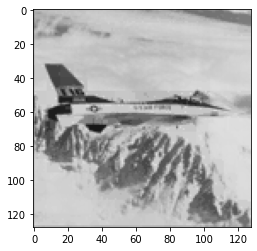

In [8]:
imagenCodigo = Cuantizacion_uniforme_adaptativa(imagen,bits=3,n_bloque = 8)
print(imagenCodigo)
imagen_cuantizada = Dibuja_imagen_cuantizada(imagenCodigo)
print(np.array(imagen_cuantizada)[0])
plt.imshow(imagen_cuantizada, cmap=plt.cm.gray,vmin=0, vmax=255)


Aplicad vuestras funciones a las imágenes que encontraréis en Atena y haced una estimación de la ratio de compresión.



# Cuantización vectorial


IMPORTANTE: K-means clustering and vector quantization 

http://docs.scipy.org/doc/scipy/reference/cluster.vq.html

Usad las funciones implementadas, en particular vq y kmeans



**Definid una funcion** `Cuantizacion_vectorial_KMeans(imagen, entradas_diccionario=2**8, n_bloque=8)` **que dada una imagen
la cuantize vectorialmente usando K-means.**

``` 
imagen: imagen a cuantizar
entradas_diccionario: número máximo de entradas del diccionario 
       usado para codificar.
n_bloque: Las entradas del diccionario serán bloques de la imagen 
       de tamaño n_bloque*n_bloque 

imagenCodigo: es una lista de la forma
[[n,m,n_bloque],Diccionario,indices]

siendo:
[n,m,n_bloque] información de la imagen
  n: número de filas de la imagen
  m: número de columnas de la imagen
  n_bloque: tamaño de los bloques usados (divisor de n y m)
Ejemplo: [1024, 1024, 8]

Diccionario: lista de arrays cuyos elementos son bloques de la 
     imagen que se usan como diccionario para cuantizar 
     vectorialmente la imagen.
Ejemplo:
    [
    array([[173, 172, 172, 171, 171, 171, 171, 172],
       [173, 172, 172, 172, 171, 171, 171, 171],
       [172, 172, 172, 172, 171, 171, 170, 170],
       [172, 172, 171, 171, 171, 171, 170, 169],
       [172, 171, 171, 171, 171, 171, 170, 169],
       [171, 171, 170, 170, 170, 170, 170, 169],
       [171, 171, 170, 170, 170, 170, 169, 169],
       [171, 171, 171, 170, 170, 169, 169, 169]], dtype=uint8), 
    array([[132, 131, 128, 122, 118, 117, 121, 124],
       [129, 132, 132, 128, 122, 119, 118, 119],
       [122, 128, 133, 133, 128, 123, 119, 116],
       [115, 121, 128, 131, 132, 130, 124, 119],
       [114, 117, 122, 126, 131, 134, 131, 126],
       [109, 114, 118, 122, 127, 133, 135, 132],
       [ 91, 102, 113, 117, 121, 127, 132, 133],
       [ 70,  89, 107, 114, 115, 120, 127, 131]], dtype=uint8)
...]

indices: array que contiene los índices de los elementos del diccionario 
    por los que hay que sustituir los bloques de la imagen.
Ejemplo: array([14, 124, 22, ...,55, 55, 356], dtype=int32)]  
    Al reconstruir la imagen el primer bloque se sustituirá por el bloque 14 
    del diccionario, el segundo se sustituirá por el bloque 124 del 
    diccionario,..., el último se substituirá por el bloque 356 del 
    diccionario.
        
      
Importante: Trabajar con Arrays de Numpy

```



In [40]:
def Cuantizacion_vectorial_KMeans(imagen, entradas_diccionario=2**8, n_bloque=8):
    
    dim = imagen.shape

    lis = [[dim[0],dim[1],n_bloque]]
    
    bloques = []
    for i in range(0,dim[0], n_bloque):
        for j in range(0,dim[1], n_bloque):
            
            bloque = imagen[i:i+n_bloque, j:j+n_bloque]
            bloques.append(bloque.flatten().astype("float"))
    dic = kmeans(bloques, entradas_diccionario)
    lis.append(np.asarray(dic)[0])
    ind, _ = vq(bloques,np.asarray(dic)[0])
    lis.append(ind)
    return lis


**Definid una función** `Dibuja_imagen_cuantizada_KMeans(imagenCodigo)`  **que dada una imagen codificada por la función** 
`Cuantizacion_vectorial_KMeans()` **muestre la imagen codificada.**



In [35]:
def Dibuja_imagen_cuantizada_KMeans(imagenCodigo):

    dims, dic, ind = imagenCodigo
    n, m, n_bloque = dims
    num_bloques_vert = n//n_bloque
    num_bloques_horz = m//n_bloque
    img = np.array([])
    img_col = np.array([])
    for i in range(num_bloques_vert):
        for j in range(num_bloques_horz):
            bloqueCodificado = ind[i*num_bloques_vert+j]
            bloqueDescodificado = dic[bloqueCodificado]
            bloqueDescodificado = np.reshape(bloqueDescodificado, (n_bloque, n_bloque)) #unflatten el bloque
            if (j == 0):
                img_col = bloqueDescodificado
            else:
                img_col = np.append(img_col, bloqueDescodificado, axis=1)
        if (i == 0):
            img = img_col
        else:
            img = np.append(img, img_col, axis=0)
    img_sol = PIL.Image.fromarray(img.astype(np.uint8))
    return img



[[202. 203. 204. ... 195. 198. 200.]
 [128. 139. 142. ... 187. 191. 191.]
 [119. 115. 120. ... 156. 189. 151.]
 ...
 [184. 187. 187. ... 207. 206. 207.]
 [197. 197. 197. ... 208. 208. 209.]
 [ 89.  96.  92. ... 173. 142. 128.]]


<ipython-input-40-1b00ef115085>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lis.append(np.asarray(dic)[0])
<ipython-input-40-1b00ef115085>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ind, _ = vq(bloques,np.asarray(dic)[0])


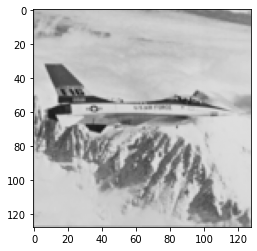

In [41]:
codigo_vectorial = Cuantizacion_vectorial_KMeans(imagen)
print((codigo_vectorial[1]))
imagen_vect_quant = Dibuja_imagen_cuantizada_KMeans(codigo_vectorial)
plt.imshow(imagen_vect_quant, cmap=plt.cm.gray,vmin=0, vmax=256)

Aplicad vuestras funciones a las imágenes que encontraréis en Atena y haced una estimación de la ratio de compresión.


# Algunas sugerencias que pueden ser útiles

Divido todos los píxeles de la imagen por $q$;

a continuación redondeo todos los píxeles;

a continuación sumo $\frac{1}{2}$ a todos los píxeles de la imagen;

a continuación convierto los valores de todos los píxeles en enteros de 8 bits sin signo;

por último múltiplico todos los píxeles de la imagen por $q$.


In [12]:
bits=3
q=2**(bits) 
imagen2=((np.floor(imagen/q)+1/2).astype(np.uint8))*q

dibujo la imagen cuanzizada resultante

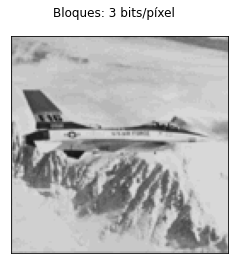

In [13]:
fig=plt.figure()
fig.suptitle('Bloques: '+str(bits)+' bits/píxel')
plt.xticks([])
plt.yticks([])
plt.imshow(imagen2, cmap=plt.cm.gray,vmin=0, vmax=255) 
plt.show()

Lectura y escritura de objetos

[[128, 128, 16, 3], [[77, 83], Array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1],
       [0, 1, 2, 2, 2, 2, 1, 2, 1, 2, 3, 1, 1, 1, 0, 1],
       [1, 2, 4, 4, 4, 4, 2, 3, 3, 2, 1, 1, 1, 1, 2, 3],
       [2, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 2, 3, 4, 4, 4],
       [2, 3, 4, 4, 2, 4, 4, 3, 3, 4, 4, 3, 4, 3, 4, 4],
       [3, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3],
       [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4],
       [4, 5, 5, 5, 5, 4, 4, 4, 4, 4, 5, 5, 6, 6, 4, 4],
       [4, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 6, 6, 4, 6],
       [6, 6, 6, 6, 5, 6, 4, 5, 6, 6, 5, 6, 6, 6, 6, 6],
       [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5],
       [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       [6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]], dtype=uint8)], [[77, 83], Array([[2, 2, 0, 1, 0, 1, 0, 0

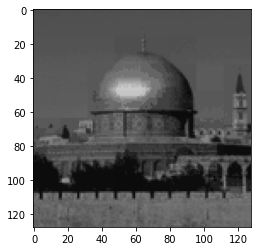

In [23]:
import pickle

fichero='DG_kSeUI'

#with  open(fichero+'.csv', 'wb') as file:
#    pickle.dump(imagenCodigo, file)
#    print(imagenCodigo)

with open(fichero+".csv", 'rb') as file:
    imagenLeidaCodificada=pickle.load(file)
    print(imagenLeidaCodificada)
    imagen_cuantizada = np.array(Dibuja_imagen_cuantizada(imagenLeidaCodificada))
    print(np.array(imagen_cuantizada)[0])
    plt.imshow(imagen_cuantizada, cmap=plt.cm.gray,vmin=0, vmax=255)
    

[array([[104, 112, 109, 120, 108, 113,  90,  83],
       [110, 106, 115, 117, 112, 105,  85,  73],
       [111, 110, 109, 111, 105, 112,  87,  86],
       [114, 105, 112, 107, 111, 111,  95,  85],
       [107, 110, 103, 106, 116, 115,  87,  83],
       [119, 107,  90,  97, 119, 107,  81,  62],
       [ 89,  92,  77,  89,  93,  85,  64,  56],
       [ 78,  83,  92,  84,  90,  82,  72,  61]], dtype=uint8), array([[66, 67, 68, 65, 66, 66, 67, 68],
       [65, 66, 65, 66, 67, 66, 66, 67],
       [66, 66, 66, 66, 66, 65, 66, 67],
       [66, 66, 66, 66, 66, 65, 66, 67],
       [65, 65, 67, 66, 65, 65, 66, 67],
       [66, 67, 67, 67, 66, 65, 66, 68],
       [68, 68, 66, 67, 69, 67, 67, 70],
       [67, 68, 66, 67, 68, 67, 67, 69]], dtype=uint8), array([[178, 190, 178, 195, 194, 212, 170, 159],
       [ 99, 111, 130, 165, 181, 167, 133, 133],
       [ 57,  67,  58,  69,  72,  73,  57,  75],
       [ 39,  35,  32,  30,  33,  30,  36,  43],
       [ 62,  66,  74,  72,  58,  56,  62,  67],
    

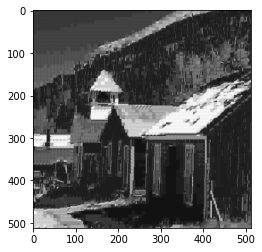

In [28]:
import pickle
with open('WOAZt_hC.csv', 'rb') as file:
    imagenLeidaCodificada2=pickle.load(file)
    print(imagenLeidaCodificada2[1])
    imagen_cuantizada2 = Dibuja_imagen_cuantizada_KMeans(imagenLeidaCodificada2)
    plt.imshow(imagen_cuantizada2, cmap=plt.cm.gray,vmin=0, vmax=255)

In [ ]:
l = [[36, 164], np.array([[7, 7, 7, 7, 7, 7, 7, 7],
       [6, 4, 4, 5, 6, 7, 7, 7],
       [1, 0, 0, 0, 1, 4, 6, 7],
       [0, 1, 1, 0, 0, 0, 1, 3],
       [6, 6, 5, 4, 2, 0, 0, 0],
       [7, 7, 7, 7, 6, 3, 1, 0],
       [7, 7, 7, 7, 6, 5, 2, 0],
       [7, 7, 7, 6, 5, 4, 2, 1]])]
                      
[l,u],bloqueCodificado = l
print(l,u,bloqueCodificado)
((bloqueCodificado)*(u-l)/8)+l

Convertir un array en imagen, mostrarla y guardarla en formato png.

La calidad por defecto con que el ecosistema python (ipython, jupyter,...) muestra las imágenes no hace justicia ni a las imágenes originales ni a las obtenidas tras la cuantización.     


In [ ]:
import PIL

imagenPIL=PIL.Image.fromarray(imagen)
imagenPIL.show()
imagenPIL.save('imagen.png', 'PNG')